<p style="font-family: 'Courier New', Courier, monospace; font-size: 50px; font-weight: bold; color: blue;  text-align: center;">
  LoRaWAN Path Loss Measurements in an Indoor Setting: EXPLORATORY DATA ANALYSIS
</p>

<div style="text-align: center;">
    <img src="lorawan.png" alt="LoRaWAN">
    <div style="text-align: right;">Photo Credit: <a href="https://onesight.solutions/wp-content/uploads/2023/10/LoraWAN-Test-Kit-Sales-Tech-Rev-2.pdf">Here</a></div>
</div>


In [3]:
# Libraries/Packages Used:

import os                          # For accessing environment variables.
from dotenv import load_dotenv      # To load environment variables from a .env file.
import pandas as pd                # For data manipulation and analysis.
import numpy as np                 # For numerical computations and handling arrays.
import math                        # For mathematical functions.
from datetime import datetime, timedelta  # For handling date and time operations.
import itertools                   # To cycle through iterables.
from itertools import cycle        # To cycle through specific iterables like colors.
import matplotlib.pyplot as plt    # For creating static visualizations.
from matplotlib.lines import Line2D # For custom lines in plots.
import seaborn as sns              # For statistical data visualization based on matplotlib.
import plotly.graph_objs as go     # For creating interactive visualizations.
from plotly.subplots import make_subplots  # For creating interactive subplots.

In [4]:
# Load environment variables from the .env file
load_dotenv()

# Run the Data_Querying notebook to fetch and prepare the data
#%run "Data_Querying.ipynb"

True

In [5]:
# Read data from a local CSV file
new_df = pd.read_csv('../all_data_files/combined_measurements_data.csv')

# Print the info about the combined DataFrame
print("\nInfo of Combined DataFrame:\n")
new_df.info()


Info of Combined DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156360 entries, 0 to 156359
Data columns (total 71 columns):
 #   Column                                                   Non-Null Count   Dtype  
---  ------                                                   --------------   -----  
 0   time                                                     156360 non-null  object 
 1   correlation_ids_0                                        156360 non-null  object 
 2   device_id                                                156360 non-null  object 
 3   end_device_ids_application_ids_application_id            156360 non-null  object 
 4   end_device_ids_dev_addr                                  156360 non-null  object 
 5   end_device_ids_dev_eui                                   156360 non-null  object 
 6   end_device_ids_device_id                                 156360 non-null  object 
 7   end_device_ids_join_eui                                  156360 non-nul

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Creating the assorted/aggregated measurements Dataframe
</p>

In [7]:
# Columns to keep and their new names for better readability
columns_to_keep = {
    'time': 'time',
    'end_device_ids_device_id': 'device_id',
    'uplink_message_decoded_payload_co2': 'co2',
    'uplink_message_decoded_payload_humidity': 'humidity',
    'uplink_message_decoded_payload_pm25': 'pm25',
    'uplink_message_decoded_payload_pressure': 'pressure',
    'uplink_message_decoded_payload_temperature': 'temperature',
    'uplink_message_rx_metadata_0_rssi': 'rssi',
    'uplink_message_rx_metadata_0_snr': 'snr',
    'uplink_message_settings_data_rate_lora_spreading_factor': 'SF',
    'uplink_message_settings_frequency': 'frequency',
    'uplink_message_f_cnt': 'f_count',
    'uplink_message_decoded_payload_packetCount' : 'p_count',
    'uplink_message_consumed_airtime' : 'toa'
}

# Select and rename columns to keep the dataset clean
cleaned_df = new_df[list(columns_to_keep.keys())].rename(columns=columns_to_keep)

# Add a 'distance' column based on device_id values
distance_map = {
    'pilotdevice'  : 10,
    'pilotdevice01': 8,
    'pilotdevice02': 25,
    'pilotdevice03': 18,
    'pilotdevice04': 37,
    'pilotdevice05': 40
}

# Map the distances to the devices
cleaned_df['distance'] = cleaned_df['device_id'].map(distance_map)

# Define the mapping for c_walls and w_walls
wall_counts_map = {
    'pilotdevice': (0, 0),
    'pilotdevice01': (1, 0),
    'pilotdevice02': (0, 2),
    'pilotdevice03': (1, 2),
    'pilotdevice04': (0, 5),
    'pilotdevice05': (2, 2)
}

# Map the c_walls and w_walls columns using the provided tuple mapping
cleaned_df[['c_walls', 'w_walls']] = cleaned_df['device_id'].map(wall_counts_map).apply(pd.Series)

# Shorten the device names for easier reference
device_name_map = {
    'pilotdevice'  : 'ED0',
    'pilotdevice01': 'ED1',
    'pilotdevice02': 'ED2',
    'pilotdevice03': 'ED3',
    'pilotdevice04': 'ED4',
    'pilotdevice05': 'ED5'
}

# Apply the name mapping so that devices now use shorter names
cleaned_df['device_id'] = cleaned_df['device_id'].map(device_name_map)

# Convert the frequency column to numeric (handling any errors) and convert to MHz
cleaned_df['frequency'] = pd.to_numeric(cleaned_df['frequency'], errors='coerce')
cleaned_df['frequency'] = cleaned_df['frequency'] / 1e6  # Hz to MHz

# Clean up the 'toa' column by removing the 's' at the end and converting to float
cleaned_df['toa'] = cleaned_df['toa'].str.rstrip('s').astype(float)

# Adding the 'experimental_PL' column based on the provided constants and formula
cleaned_df = cleaned_df.assign(
    exp_pl = 14 - 1 + 1.4 + 3 - cleaned_df['rssi']  
    # Using the exact values: tx_p=14, tx_cl=1, tx_ag=1.4, rx_ag=3
)

# Calculate Noise Power (n_power) in dBm
cleaned_df = cleaned_df.assign(
    n_power = cleaned_df['rssi'] - 10 * np.log10(np.power(10, cleaned_df['snr'] / 10) + 1)
)

# Calculate Effective Signal Power (esp) in dBm
cleaned_df = cleaned_df.assign(
    esp = cleaned_df['n_power'] + cleaned_df['snr']
)

# Save the cleaned and aggregated data to a CSV file 
cleaned_df.to_csv('aggregated_measurements_data.csv', index=False)

# Display DataFrame information to confirm everything
cleaned_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156360 entries, 0 to 156359
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         156360 non-null  object 
 1   device_id    156360 non-null  object 
 2   co2          156360 non-null  float64
 3   humidity     156360 non-null  float64
 4   pm25         156360 non-null  float64
 5   pressure     156360 non-null  float64
 6   temperature  156360 non-null  float64
 7   rssi         156360 non-null  float64
 8   snr          156013 non-null  float64
 9   SF           156360 non-null  float64
 10  frequency    156360 non-null  float64
 11  f_count      156360 non-null  float64
 12  p_count      156360 non-null  float64
 13  toa          156360 non-null  float64
 14  distance     156360 non-null  int64  
 15  c_walls      156360 non-null  int64  
 16  w_walls      156360 non-null  int64  
 17  exp_pl       156360 non-null  float64
 18  n_power      156013 non-

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Channel Usage Transmissions Confirmation / Check
</p>

C:\Users\User\AppData\Local\Temp\ipykernel_28752\1298071955.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=channel_counts.index, y=channel_counts.values, palette='viridis')


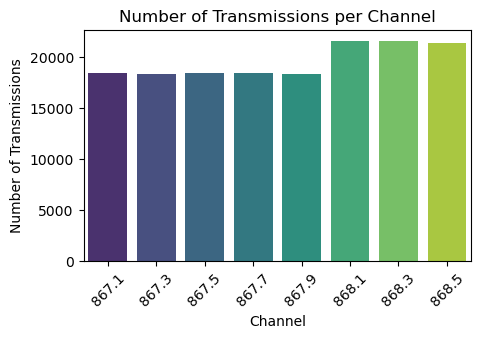

In [9]:
# Count transmissions per channel
channel_counts = cleaned_df['frequency'].value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(5,3))
sns.barplot(x=channel_counts.index, y=channel_counts.values, palette='viridis')
plt.title('Number of Transmissions per Channel')
plt.xlabel('Channel')
plt.ylabel('Number of Transmissions')
plt.xticks(rotation=45)
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Packet Delivery Ratio (PDR)
</p>

In [11]:
# Grouping data by device_id
grouped = cleaned_df.groupby('device_id')

# Calculating the total sent and received packets
pdr_table = grouped.agg(
    total_sent_packets=('p_count', 'max'),
    received_packets=('f_count', 'max')
)

# Calculating the PDR
pdr_table['PDR (%)'] = (pdr_table['received_packets'] / pdr_table['total_sent_packets']) * 100

# Displaying the result as a table
pdr_table


,total_sent_packets,received_packets,PDR (%)
device_id,,,
ED0,28035.0,25122.0,89.609417
ED1,28024.0,25064.0,89.437625
ED2,28036.0,24922.0,88.892852
ED3,28024.0,24992.0,89.180702
ED4,32142.0,28357.0,88.224130
ED5,32155.0,29508.0,91.767999


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Checking Anomalies with BOX PLOTS
</p>

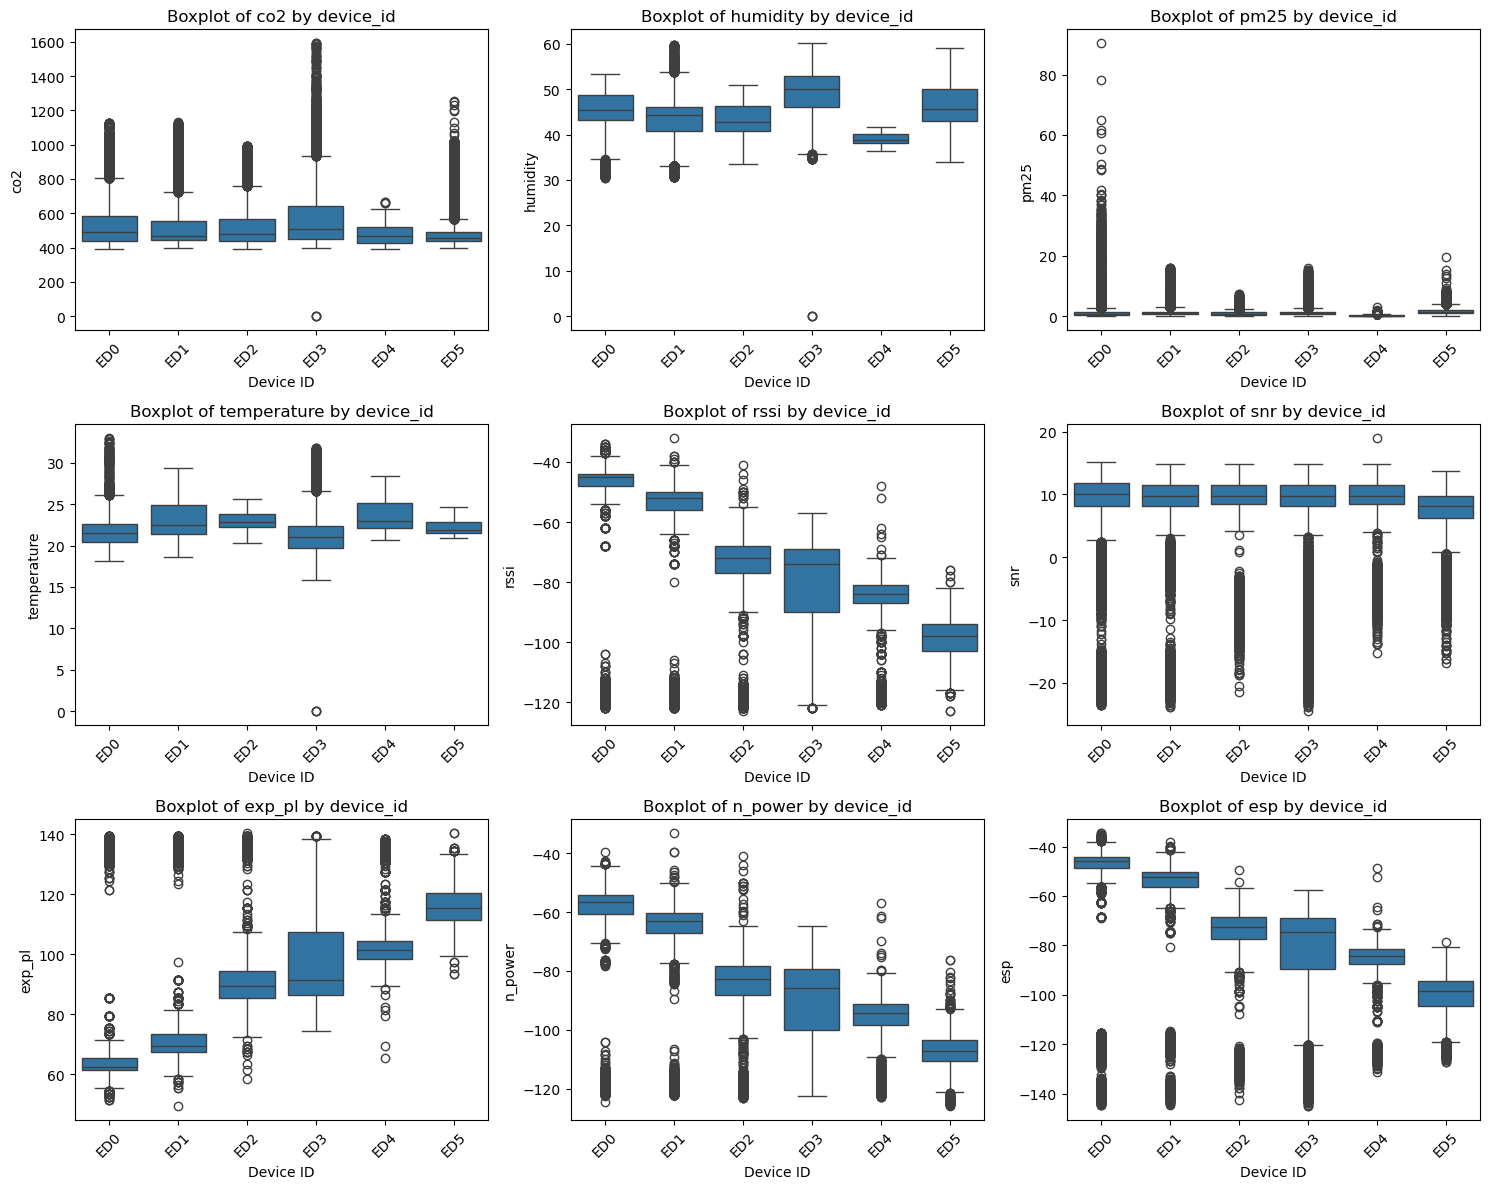

In [13]:
# Columns to exclude
exclude_cols = ['f_count', 'p_count', 'c_walls', 'w_walls', 'frequency', 'SF', 'toa', 'distance', 'pressure']

# Select numeric columns excluding 'f_count' and 'p_count'
numeric_cols = cleaned_df.select_dtypes(include=['float64', 'int64']).columns.drop(exclude_cols)

# Define the desired order for device_id
desired_order = ['ED0', 'ED1', 'ED2', 'ED3', 'ED4', 'ED5'] 

# Ensure 'device_id' is a categorical type with the specified order
cleaned_df['device_id'] = pd.Categorical(cleaned_df['device_id'], categories=desired_order, ordered=True)

# Determine the number of plots
num_vars = len(numeric_cols)
cols = 3  # Number of columns in the subplot grid
rows = math.ceil(num_vars / cols)

# Set the overall figure size
plt.figure(figsize=(cols * 5, rows * 4))

# Iterate over each numeric column and create a subplot
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, idx)
    sns.boxplot(x='device_id', y=col, data=cleaned_df, order=desired_order)
    plt.title(f'Boxplot of {col} by device_id')
    plt.xlabel('Device ID')
    plt.ylabel(col)
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Visual Dataframe Cleaning
</p>

In [15]:
# Exclude all rows where 'rssi' looks anomalous
# cleaned_df = cleaned_df[cleaned_df['rssi'] > -116]

# Define RSSI thresholds for each device
rssi_thresholds = {
    'ED0': -100.0,
    'ED1': -100.0,
    'ED2': -100.0,
    'ED3': -130.0,
    'ED4': -116.0,
    'ED5': -131.0
}

# Apply the thresholds using the map and filter the DataFrame
#cleaned_df = cleaned_df[cleaned_df['rssi'] > cleaned_df['device_id'].map(rssi_thresholds)]

# Resetting the index after filtering
#cleaned_df.reset_index(drop=True, inplace=True)

# Exclude data points for device ED4
#cleaned_df = cleaned_df[~cleaned_df['device_id'].isin(['ED4'])]

# Exclude SFxx and SF12 datapoints
#cleaned_df = cleaned_df[~cleaned_df['SF'].isin([12])]

# Remove rows with a temperature above 30
#cleaned_df = cleaned_df[~(cleaned_df['temperature'] > 30)]
# Remove rows with humidity below 20
#cleaned_df = cleaned_df[~(cleaned_df['humidity'] < 20)]


# Remove rows with SNR that is negative
#cleaned_df = cleaned_df[~(cleaned_df['snr'] < -3)]

# Save all data to csv
cleaned_df.to_csv('../all_data_files/visually_cleaned_df.csv', index=False)

# Display the cleaned Dataframe Info
print("\nInfo of Combined DataFrame:\n")
cleaned_df.info()

# Display the cleaned Dataframe Head and Tail
print("\nCleaned DataFrame:\n")
cleaned_df



Info of Combined DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156360 entries, 0 to 156359
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   time         156360 non-null  object  
 1   device_id    156360 non-null  category
 2   co2          156360 non-null  float64 
 3   humidity     156360 non-null  float64 
 4   pm25         156360 non-null  float64 
 5   pressure     156360 non-null  float64 
 6   temperature  156360 non-null  float64 
 7   rssi         156360 non-null  float64 
 8   snr          156013 non-null  float64 
 9   SF           156360 non-null  float64 
 10  frequency    156360 non-null  float64 
 11  f_count      156360 non-null  float64 
 12  p_count      156360 non-null  float64 
 13  toa          156360 non-null  float64 
 14  distance     156360 non-null  int64   
 15  c_walls      156360 non-null  int64   
 16  w_walls      156360 non-null  int64   
 17  exp_pl       15636

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-09-26 13:00:52.541686+02:00,ED3,633.0,54.22,0.58,300.41,23.85,-71.0,12.2,10.0,867.9,94.0,104.0,0.452608,18,1,2,88.4,-83.454107,-71.254107
1,2024-09-26 13:00:52.542462+02:00,ED3,633.0,54.22,0.58,300.41,23.85,-71.0,12.2,10.0,867.9,94.0,104.0,0.452608,18,1,2,88.4,-83.454107,-71.254107
2,2024-09-26 13:01:08.336258+02:00,ED0,541.0,49.34,0.46,299.70,24.57,-52.0,13.2,9.0,868.1,81.0,108.0,0.246784,10,0,0,69.4,-65.403045,-52.203045
3,2024-09-26 13:01:08.338296+02:00,ED0,541.0,49.34,0.46,299.70,24.57,-52.0,13.2,9.0,868.1,81.0,108.0,0.246784,10,0,0,69.4,-65.403045,-52.203045
4,2024-09-26 13:01:14.477162+02:00,ED1,475.0,45.28,0.23,300.73,25.63,-58.0,8.5,9.0,867.5,80.0,106.0,0.246784,8,1,0,75.4,-67.073822,-58.573822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156355,2024-10-15 23:03:34.968597+02:00,ED4,530.0,40.78,0.32,325.14,20.78,-114.0,-9.5,10.0,867.5,28357.0,32142.0,0.452608,37,0,5,131.4,-114.461836,-123.961836
156356,2024-10-15 23:03:50.289837+02:00,ED2,519.0,40.74,1.18,324.25,22.26,-68.0,11.8,10.0,868.3,24919.0,28033.0,0.452608,25,0,2,85.4,-80.077855,-68.277855
156357,2024-10-15 23:04:51.314333+02:00,ED0,500.0,41.56,1.27,322.81,21.95,-117.0,-2.0,10.0,867.7,25119.0,28032.0,0.452608,10,0,0,134.4,-119.124426,-121.124426
156358,2024-10-15 23:05:02.348426+02:00,ED2,512.0,40.73,1.14,324.23,22.27,-68.0,9.2,9.0,868.5,24922.0,28036.0,0.246784,25,0,2,85.4,-77.693058,-68.493058


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Plot for Some Dataframe variables over time
</p>

In [17]:
def plot_sensor_readings(cleaned_df, row_map):
    """
    Plots sensor readings by grouping devices and assigning colors dynamically.
    Ensures the plot is fully visible in Jupyter notebooks without scrolling.

    Args:
    - cleaned_df (DataFrame): Cleaned DataFrame containing sensor data.
    - row_map (dict): Mapping of sensor parameters to subplot rows.
    """
    # Create subplots dynamically based on the row_map provided
    fig = make_subplots(
        rows=len(row_map), cols=1, 
        subplot_titles=[f'{param.title()} Readings Over Time' for param in row_map]
    )

    # Define a pool of colors and create an iterator to cycle through them
    color_pool = itertools.cycle(['green', 'red', 'blue', 'purple', 'orange', 
                                  'cyan', 'magenta', 'brown', 'black', 'pink'])
    
    # Group by unique device IDs and assign colors dynamically
    device_colors = {device: next(color_pool) for device in cleaned_df['device_id'].unique()}

    # Set to track which devices have already been added to the legend
    devices_in_legend = set()

    # Plotting for each parameter and each device
    for param, row in row_map.items():
        for device, color in device_colors.items():
            # Filter data for the specific device
            data = cleaned_df[cleaned_df['device_id'] == device]
            
            # Add a trace for each parameter for the current device
            fig.add_trace(
                go.Scatter(
                    x=data['time'], 
                    y=data[param], 
                    mode='lines',  # Line plot
                    name=f"{device}" if device not in devices_in_legend else None,  # Add device to legend once
                    line=dict(color=color),
                    showlegend=device not in devices_in_legend  # Only show legend if the device hasn't been added yet
                ),
                row=row, col=1  # Place in the correct subplot
            )

            # Mark the device as added to the legend
            devices_in_legend.add(device)

    # Update layout with fixed height and other settings
    fig.update_layout(
        height=1800,  # Fixed height to accommodate all subplots
        showlegend=True,  # Show legend
        title_text="Sensor Readings Over Time",  # Overall plot title
        legend=dict(title="Devices", x=1.05, y=1)  # Adjust legend position
    )

    # Show the plot
    fig.show()

# Example usage:
# Define the row mapping for parameters; can be modified as needed
row_map = {
    'temperature': 1, 'humidity': 2, 'co2': 3, 'pm25': 4, 
    'pressure': 5, 'rssi': 6, 'snr': 7, 'p_count': 8, 'f_count': 9
}

# Calling the function with the cleaned DataFrame and row_map
#plot_sensor_readings(cleaned_df, row_map)

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold;
color: blue;  text-align: left;">
  Statistical Description
</p>

In [19]:
# Generate the statistical description of the cleaned DataFrame
stat_description = cleaned_df.describe().transpose()

# Set the display format for floating-point numbers to 3 decimal places
pd.options.display.float_format = '{:,.3f}'.format 

# Save the statistical description to an Excel file
excel_path = "statistical_description.xlsx"
stat_description.to_excel(excel_path)

# Display the statistical description
stat_description

,count,mean,std,min,25%,50%,75%,max
co2,"156,360.000",514.095,115.588,0.000,439.000,472.000,547.000,"1,593.000"
humidity,"156,360.000",44.492,5.128,0.000,40.610,44.300,47.870,60.190
pm25,"156,360.000",1.125,1.533,0.000,0.420,0.830,1.400,90.460
pressure,"156,360.000",315.674,9.529,286.910,308.500,316.860,323.590,334.370
temperature,"156,360.000",22.469,2.003,0.000,21.350,22.210,23.640,33.010
rssi,"156,360.000",-77.342,23.411,-123.000,-94.000,-77.000,-54.000,-32.000
snr,"156,013.000",7.715,6.534,-24.500,8.000,9.500,11.200,19.000
SF,"156,360.000",9.322,1.689,7.000,8.000,9.000,11.000,12.000
frequency,"156,360.000",867.830,0.461,867.100,867.500,867.900,868.300,868.500
f_count,"156,360.000","12,287.411","7,730.967",76.000,"5,409.000","11,906.500","18,619.000","29,508.000"


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold;
color: blue;  text-align: left;">
  Correlation Matrix and the HeatMap
</p>

In [21]:
# Select only the numeric columns
numeric_df = cleaned_df.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Set the display format for floating-point numbers to xx decimal places
pd.options.display.float_format = '{:,.3f}'.format 

# Display the Correlation Matrix
correlation_matrix

,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
co2,1.000,0.256,0.353,-0.058,0.014,0.107,0.018,-0.001,-0.003,0.321,0.321,-0.000,-0.187,-0.016,-0.136,-0.107,0.110,0.096
humidity,0.256,1.000,0.067,-0.492,-0.481,0.033,-0.025,0.002,-0.000,0.082,0.071,0.001,-0.185,0.322,-0.321,-0.033,0.038,0.025
pm25,0.353,0.067,1.000,0.127,-0.047,0.036,0.001,0.000,-0.001,0.120,0.113,-0.000,-0.084,0.192,-0.230,-0.036,0.040,0.034
pressure,-0.058,-0.492,0.127,1.000,-0.109,-0.036,-0.012,0.002,0.001,0.145,0.147,0.001,0.029,-0.023,0.052,0.036,-0.038,-0.035
temperature,0.014,-0.481,-0.047,-0.109,1.000,-0.060,0.006,-0.003,0.001,-0.351,-0.348,-0.003,0.150,-0.107,0.206,0.060,-0.063,-0.051
rssi,0.107,0.033,0.036,-0.036,-0.060,1.000,0.653,-0.287,0.001,-0.055,-0.051,-0.357,-0.574,-0.311,-0.440,-1.000,0.993,0.994
snr,0.018,-0.025,0.001,-0.012,0.006,0.653,1.000,-0.375,-0.065,0.055,0.056,-0.500,0.011,-0.042,0.027,-0.653,0.565,0.727
SF,-0.001,0.002,0.000,0.002,-0.003,-0.287,-0.375,1.000,0.081,0.002,0.002,0.907,0.002,0.004,-0.002,0.287,-0.257,-0.310
frequency,-0.003,-0.000,-0.001,0.001,0.001,0.001,-0.065,0.081,1.000,-0.001,-0.001,0.086,0.004,0.004,0.001,-0.001,0.017,-0.002
f_count,0.321,0.082,0.120,0.145,-0.351,-0.055,0.055,0.002,-0.001,1.000,1.000,0.001,0.205,0.095,0.146,0.055,-0.072,-0.046


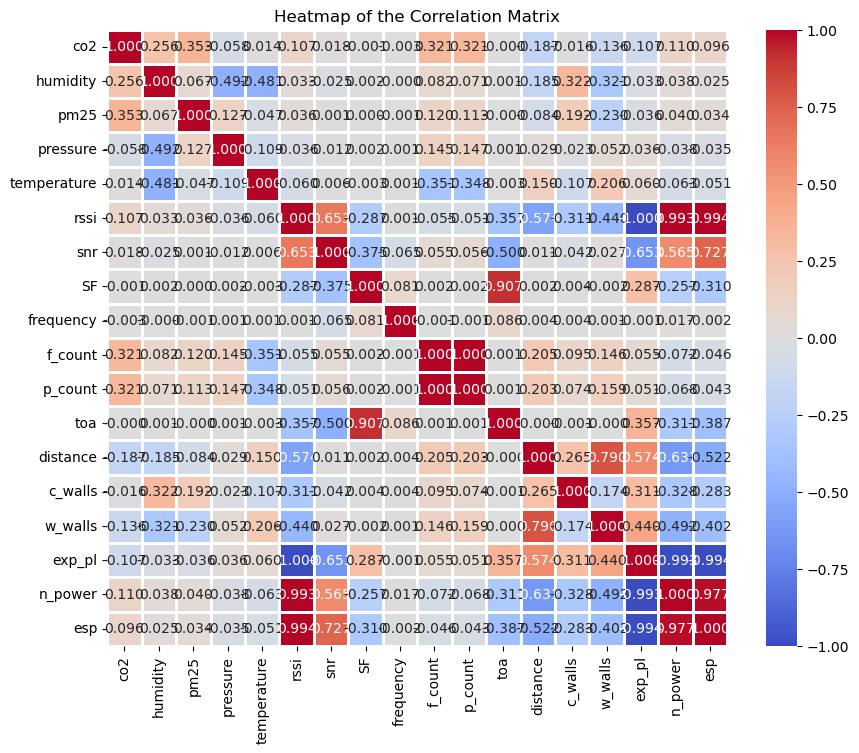

In [22]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.8)
plt.title('Heatmap of the Correlation Matrix')
plt.show()

In [23]:
#Single out RSSI and sort the values
numeric_df.corr()['rssi'].sort_values()

exp_pl        -1.000
distance      -0.574
w_walls       -0.440
toa           -0.357
c_walls       -0.311
SF            -0.287
temperature   -0.060
f_count       -0.055
p_count       -0.051
pressure      -0.036
frequency      0.001
humidity       0.033
pm25           0.036
co2            0.107
snr            0.653
n_power        0.993
esp            0.994
rssi           1.000
Name: rssi, dtype: float64

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Scatter Plots : SNR vs RSSI for each Devices
</p>

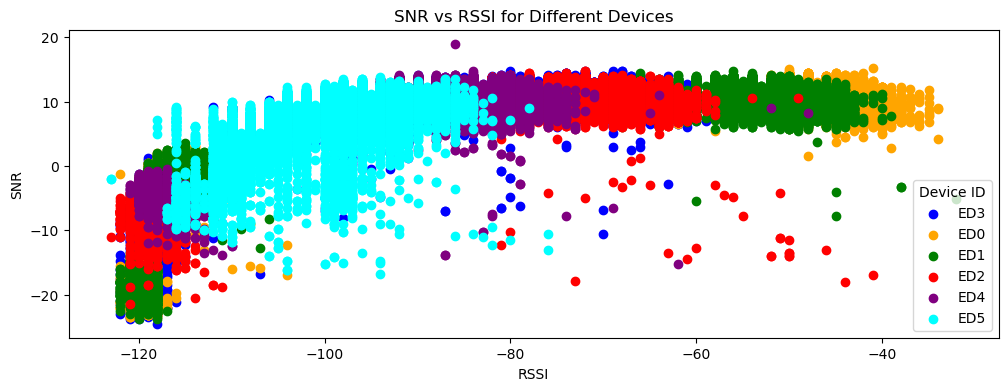

In [25]:
def plot_snr_vs_rssi(cleaned_df):
    """
    Plots SNR vs RSSI for each device dynamically using different colors.

    Args:
    - cleaned_df (DataFrame): Cleaned DataFrame containing sensor data with 'rssi' and 'snr' columns.
    """
    # Define a pool of colors and create an iterator to cycle through them
    color_pool = itertools.cycle(['blue', 'orange', 'green', 'red', 'purple', 
                                  'cyan', 'magenta', 'brown', 'black', 'pink'])

    # Create a figure for plotting
    plt.figure(figsize=(12, 4))

    # Group by unique device IDs and assign colors dynamically
    for device, color in zip(cleaned_df['device_id'].unique(), color_pool):
        # Filter data for each device
        subset = cleaned_df[cleaned_df['device_id'] == device]
        # Scatter plot for SNR vs RSSI
        plt.scatter(subset['rssi'], subset['snr'], label=device, color=color)

    # Add labels, legend, and title
    plt.xlabel('RSSI')
    plt.ylabel('SNR')
    plt.legend(title='Device ID')
    plt.title('SNR vs RSSI for Different Devices')

    # Show the plot
    plt.show()

# Example usage:
plot_snr_vs_rssi(cleaned_df)


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Exploration of LoRAWAN Parameters based on the Spreading Factor
</p>

C:\Users\User\AppData\Local\Temp\ipykernel_28752\4105872326.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for device_id, device_data in cleaned_df.groupby('device_id'):


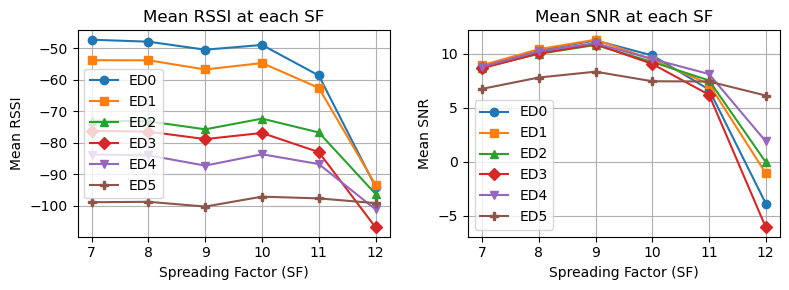

In [27]:
def plot_mean_metric(ax, cleaned_df, metric, ylabel, title):
    """
    Plots the mean of a specified metric grouped by Spreading Factor (SF) for each device.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - cleaned_df (DataFrame): DataFrame containing sensor data with 'device_id', 'SF', and metric columns.
    - metric (str): The metric to plot (e.g., 'rssi', 'snr', 'toa').
    - ylabel (str): The label for the y-axis.
    - title (str): The title of the plot.
    """
    # Define a pool of markers to use for different devices
    marker_pool = itertools.cycle(['o', 's', '^', 'D', 'v', 'P', '*'])
    
    # Group by device and calculate mean metric for each SF
    for device_id, device_data in cleaned_df.groupby('device_id'):
        mean_metric = device_data.groupby('SF')[metric].mean()
        # Plot mean metric for each device with a different marker
        ax.plot(mean_metric.index, mean_metric.values, marker=next(marker_pool), linestyle='-', label=device_id)
    
    # Set labels and title
    ax.set_xlabel('Spreading Factor (SF)')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Set up the matplotlib figure with subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot mean RSSI
plot_mean_metric(axes[0], cleaned_df, 'rssi', 'Mean RSSI', 'Mean RSSI at each SF')

# Plot mean SNR
plot_mean_metric(axes[1], cleaned_df, 'snr', 'Mean SNR', 'Mean SNR at each SF')

# Adjust layout
plt.tight_layout()

# Save the figure 
plt.savefig('../all_data_files/rssi_and_snr_per_SF.png', dpi=800)

# Show the plot
plt.show()

In [28]:
# Calculate the mean of rssi, snr and exp_pl grouped by device_id
mean_values = cleaned_df.groupby('device_id')[['rssi', 'snr', 'exp_pl']].mean()

# Display the mean values
mean_values

C:\Users\User\AppData\Local\Temp\ipykernel_28752\3998758692.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = cleaned_df.groupby('device_id')[['rssi', 'snr', 'exp_pl']].mean()


,rssi,snr,exp_pl
device_id,,,
ED0,-56.613,7.577,74.013
ED1,-61.377,8.060,78.777
ED2,-77.308,7.973,94.708
ED3,-82.239,6.892,99.639
ED4,-87.384,8.457,104.784
ED5,-98.708,7.348,116.108


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 KDE Plots: Environmental Parameters & LoRaWAN Signal PARAMETERS
</p>

C:\Users\User\AppData\Local\Temp\ipykernel_28752\3418925384.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = data.pivot_table(index=parameter, columns='device_id', aggfunc='size', fill_value=0)
C:\Users\User\AppData\Local\Temp\ipykernel_28752\3418925384.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = data.pivot_table(index=parameter, columns='device_id', aggfunc='size', fill_value=0)


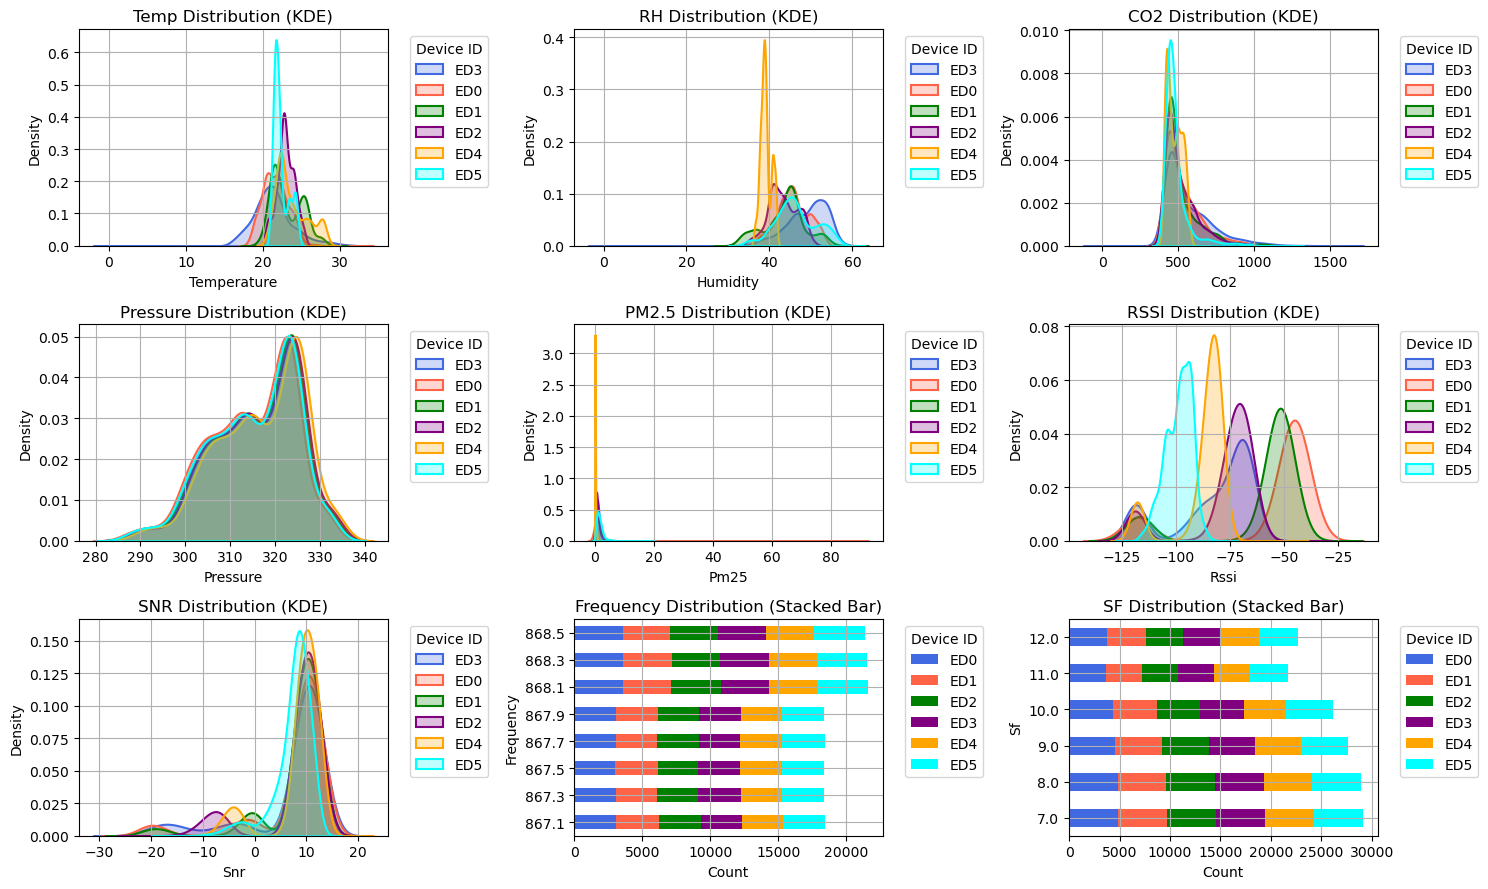

In [30]:
def plot_stacked_bar(ax, data, parameter, title=''):
    """
    Plots a stacked bar chart for the given parameter, grouping by 'device_id'.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - data (DataFrame): DataFrame containing sensor data with 'device_id' and the parameter to plot.
    - parameter (str): The parameter to plot (e.g., 'frequency', 'SF', 'distance').
    - title (str): The title of the plot.
    """
    # Define a pool of colors to use for different devices
    color_pool = itertools.cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 'cyan', 'magenta'])
    
    # Pivot the data to have device_id as columns
    pivot_data = data.pivot_table(index=parameter, columns='device_id', aggfunc='size', fill_value=0)
    
    # Create a color map dynamically based on device_id
    colors = {device: next(color_pool) for device in pivot_data.columns}

    # Plot the stacked bar plot
    pivot_data.plot(kind='barh', stacked=True, ax=ax, color=[colors[device] for device in pivot_data.columns])
    
    ax.set_title(title)
    ax.set_xlabel('Count')
    ax.set_ylabel(parameter.capitalize())
    ax.grid(True)
    ax.legend(title='Device ID', bbox_to_anchor=(1.05, 1), loc='upper left')

def plot_kde(ax, data, parameter, bw_adjust=2, title=''):
    """
    Plots a Kernel Density Estimate (KDE) for the given parameter, grouped by 'device_id'.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - data (DataFrame): DataFrame containing sensor data with 'device_id' and the parameter to plot.
    - parameter (str): The parameter to plot (e.g., 'temperature', 'humidity', 'co2').
    - bw_adjust (float): Bandwidth adjustment for the KDE plot.
    - title (str): The title of the plot.
    """
    # Define a pool of colors to use for different devices
    color_pool = itertools.cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 'cyan', 'magenta'])

    # Create a color map dynamically based on device_id
    colors = {device_id: next(color_pool) for device_id in data['device_id'].unique()}

    # Plot KDE for each device
    for device_id in data['device_id'].unique():
        subset = data[data['device_id'] == device_id]
        sns.kdeplot(
            subset[parameter], ax=ax, 
            label=device_id, 
            lw=1.5, 
            bw_adjust=bw_adjust, 
            fill=True, 
            color=colors[device_id]
        )
    
    ax.set_title(title)
    ax.set_xlabel(parameter.capitalize())
    ax.set_ylabel('Density')
    ax.grid(True)
    ax.legend(title='Device ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Filter the DataFrame (if needed) or use as is
filtered_df = cleaned_df[cleaned_df['device_id'].isin(cleaned_df['device_id'].unique())]

# Set up the matplotlib figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 9))

# Plot each parameter on a separate subplot
plot_kde(axes[0, 0], filtered_df, 'temperature', bw_adjust=2, title='Temp Distribution (KDE)')
plot_kde(axes[0, 1], filtered_df, 'humidity', bw_adjust=2, title='RH Distribution (KDE)')
plot_kde(axes[0, 2], filtered_df, 'co2', bw_adjust=2, title='CO2 Distribution (KDE)')
plot_kde(axes[1, 0], filtered_df, 'pressure', bw_adjust=2, title='Pressure Distribution (KDE)')
plot_kde(axes[1, 1], filtered_df, 'pm25', bw_adjust=2, title='PM2.5 Distribution (KDE)')
plot_kde(axes[1, 2], filtered_df, 'rssi', bw_adjust=2, title='RSSI Distribution (KDE)')
plot_kde(axes[2, 0], filtered_df, 'snr', bw_adjust=2, title='SNR Distribution (KDE)')

# Plot the stacked bar charts on the last two subplots
plot_stacked_bar(axes[2, 1], filtered_df, 'frequency', title='Frequency Distribution (Stacked Bar)')
plot_stacked_bar(axes[2, 2], filtered_df, 'SF', title='SF Distribution (Stacked Bar)')

# If there are any unused subplots, we could hide them here
# In this case, all 9 subplots are used

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('../all_data_files/signal_environmental_dist.png', dpi=800)

# Show the plot
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 LoRaWAN Effective Signal Power vs Noise Power
</p>

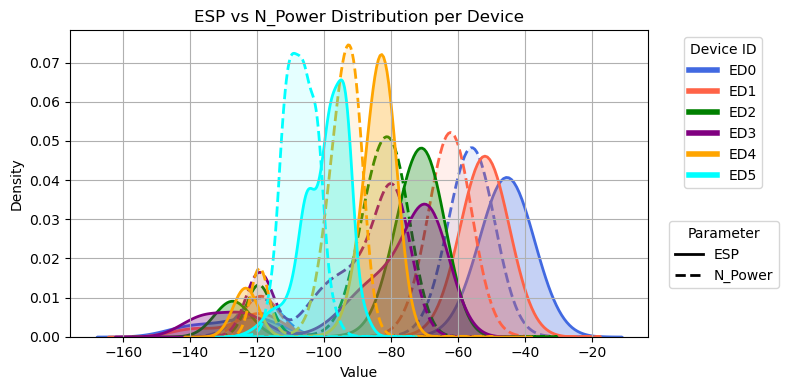

In [32]:
def plot_esp_n_power_comparison(ax, data, bw_adjust=2, title='ESP vs N_Power Distribution per Device'):
    """
    Compare 'esp' and 'n_power' distributions per device using KDE plots.
    'ESP' is dashed and 'N_Power' is solid.
    """
    # Assign colors to each device
    color_pool = cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'olive', 'pink'])
    devices = sorted(data['device_id'].unique())
    colors = {device: next(color_pool) for device in devices}
    
    for device in devices:
        subset = data[data['device_id'] == device]
        # Plot 'ESP' with solid line
        sns.kdeplot(
            subset['esp'], ax=ax, label=f'{device} - ESP', lw=2, bw_adjust=bw_adjust,
            linestyle='-', color=colors[device], fill=True, alpha=0.3
        )
        # Plot 'N_Power' with dashed line
        sns.kdeplot(
            subset['n_power'], ax=ax, label=f'{device} - N_Power', lw=2, bw_adjust=bw_adjust,
            linestyle='--', color=colors[device], fill=True, alpha=0.1
        )
    
    # Set titles and labels
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.grid(True)
    
    # Create legends
    device_handles = [Line2D([0], [0], color=colors[device], lw=4) for device in devices]
    device_labels = devices
    parameter_handles = [
        Line2D([0], [0], color='black', lw=2, linestyle='-'),
        Line2D([0], [0], color='black', lw=2, linestyle='--')
    ]
    parameter_labels = ['ESP', 'N_Power']
    
    # Add device legend
    legend1 = ax.legend(device_handles, device_labels, title='Device ID',
                        bbox_to_anchor=(1.05, 1), loc='upper left')
    # Add parameter legend
    legend2 = ax.legend(parameter_handles, parameter_labels, title='Parameter',
                        bbox_to_anchor=(1.025, 0.4), loc='upper left')
    ax.add_artist(legend1)

# Plotting the comparison
fig, ax = plt.subplots(figsize=(8, 4))
plot_esp_n_power_comparison(ax, filtered_df, bw_adjust=2, title='ESP vs N_Power Distribution per Device')
plt.tight_layout()

# Save the plot
plt.savefig('../all_data_files/esp_n_power_comparison.png', dpi=800)

# Display the plot
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 PLM Modelling and Comaprison
</p>



 Multi-Wall Model Fitting
Total number of rows: 133702
Rows with NaN or Inf: 167 (0.12%)
Rows after cleaning: 133535 (99.88%)

=== Table of Parameters to be Compared ===



,Parameter,LDPLM - MW,LDPLM - MW - EP
0,PL(d0) [dB],25.670,-25.245
1,Path loss exponent (n),4.308,3.674
2,Brick Wall Loss (L_c) [dB],9.059,7.937
3,Wood Wall Loss (L_w) [dB],2.078,2.782
4,CO2 coefficient (a_co2) [dB/unit],-,-0.000
5,Humidity coefficient (a_hum) [dB/unit],-,0.059
6,PM2.5 coefficient (a_pm25) [dB/unit],-,-0.044
7,Pressure coefficient (a_pres) [dB/unit],-,0.048
8,Temperature coefficient (a_temp) [dB/unit],-,0.093
9,SNR scaling factor (k_snr),-,2.186



=== Performance Metrics Comparison ===



,LDPLM - MW,LDPLM - MW - EP
RMSE (dB),13.121,8.886
R-squared,0.610,0.821
Shadowing σ (dB),13.235,8.941


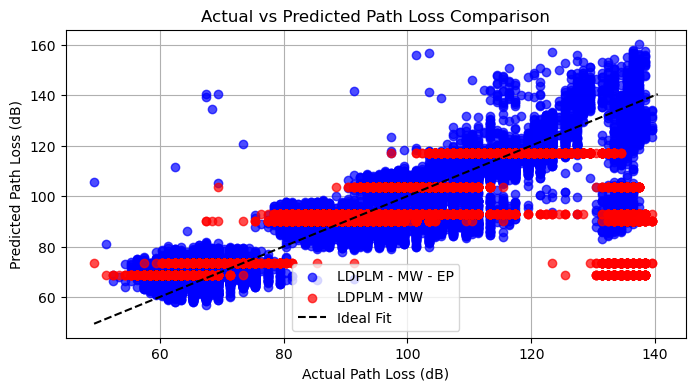

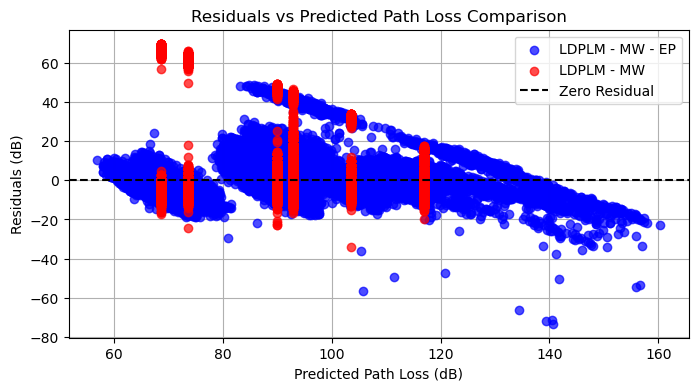

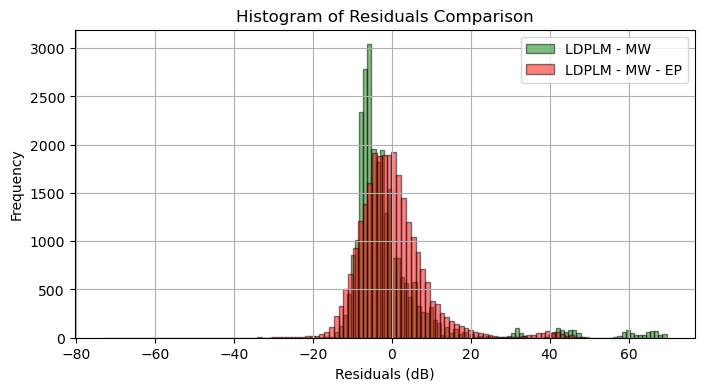


Residual Distribution Values:

LDPLM - MW: Mean:-0.03 dB, Skewness: 3.3004 dB
LDPLM - MW - EP: Mean:0.0399 dB, Skewness: 1.5097 dB

=== Cross-Validation (5-Fold) ===

Fold 1: LDPLM - MW RMSE = 13.12 dB, R-squared = 0.6104; LDPLM - MW - EP RMSE = 8.89 dB, R-squared = 0.8214
Fold 2: LDPLM - MW RMSE = 13.43 dB, R-squared = 0.5989; LDPLM - MW - EP RMSE = 8.99 dB, R-squared = 0.8205
Fold 3: LDPLM - MW RMSE = 13.28 dB, R-squared = 0.6093; LDPLM - MW - EP RMSE = 8.98 dB, R-squared = 0.8215
Fold 4: LDPLM - MW RMSE = 13.18 dB, R-squared = 0.6161; LDPLM - MW - EP RMSE = 8.95 dB, R-squared = 0.8230
Fold 5: LDPLM - MW RMSE = 13.05 dB, R-squared = 0.6219; LDPLM - MW - EP RMSE = 8.86 dB, R-squared = 0.8257

Average RMSE across folds:
LDPLM - MW: 13.21 dB
LDPLM - MW - EP: 8.93 dB

Average R-squared across folds:
LDPLM - MW: 0.6113
LDPLM - MW - EP: 0.8224


In [34]:
# Run the two Fitting Models [Multi-wall & the Enhanced] NoteBook and Check Results here

print('\n\n Multi-Wall Model Fitting')
%run "LDPLM - BOTH.ipynb"
